#### Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps 
from scipy.stats import norm
from utils.print_utils import print_model
from utils.model_utils import grind_hyper_search,threshold_remove


#### Synthetic Option

In [2]:

def black_scholes_call_time_(S,K,T,r,sigma):
    '''
    Generate the values of the black scholes equation differentiate with respect to time
    '''
    d1 = 1/(sigma*np.sqrt(T))*(np.log(S/K) + (r + (sigma**2)/2)*T)
    call_time = - K * np.exp(-r * T) * r * norm.cdf(d1  - sigma * np.sqrt(T)) - S * ((sigma)/(2*np.sqrt(T))) * norm.pdf(d1)
    return call_time

def black_scholes_call(S, X, T, r, sigma):
    '''
    Generate the price of an option through the black scholes equation
    '''
    d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / X) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    call_price = S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def numerical_partial_black_scholes(V,r,sigma):
    '''
    Numerical calculation of the black-scholes through DURA-MOS¸NEAGU
    '''
    N = len(V[0])
    M = len(V[:,0])
    V_dot = np.zeros([M,N])

    alpha = 0.5*(sigma**2)
    beta = 0.5*r

    #Calculate option-value
    for m in range(M):
        v_m = []
        for n in range(1,N-1):
                v_m.append((beta*n - alpha*(n**2))*V[m,n-1] + 2*(beta + alpha*(n**2))*V[m,n] - (alpha*(n**2) + beta*n)*V[m,n+1])
        V_dot[m] = [0] + v_m + [0]
    return V_dot

In [3]:
# Constants
r = 0.05
sigma = 0.4
K = 105
T = 1.

timesteps = 1200
spacesteps =  110

# Monte Carlo simulation
x = np.linspace(0., K*3, spacesteps)
t = np.linspace(0, T, timesteps)
X, T = np.meshgrid(x, t)

dt = t[1] - t[0]
dx = x[1] - x[0]

X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

# Calculate 'tal' using vectorized operations
tal = (np.max(t) - T)

# Calculate the call prices using vectorized operations
call_prices = black_scholes_call(X, K, tal, r, sigma)

# u is the call_prices array
u = call_prices.T

u_t = black_scholes_call_time_(X, K, tal, r, sigma).T[:,:-1]

C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_12716\891614714.py:13: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_12716\891614714.py:13: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_12716\891614714.py:14: RuntimeWarning: divide by zero encountered in log
  d2 = (np.log(S / X) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_12716\891614714.py:14: RuntimeWarning: divide by zero encountered in divide
  d2 = (np.log(S / X) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_12716\891614714.py:5: RuntimeWarning: divide by zero encountered in divide
  d1 = 1/(sigma*np.sqrt(T))*(np.log(S/K) + (r + (sigma**2)/2)*T)
C:\Users\Bruno 

Error for Finite Difference 
RSE 1.333856748063213e-06
RMSE 2.1439182652515885
Error for Numerical Black-Scholes
RSE 0.0004104449956065904
RMSE 37.6080756338261


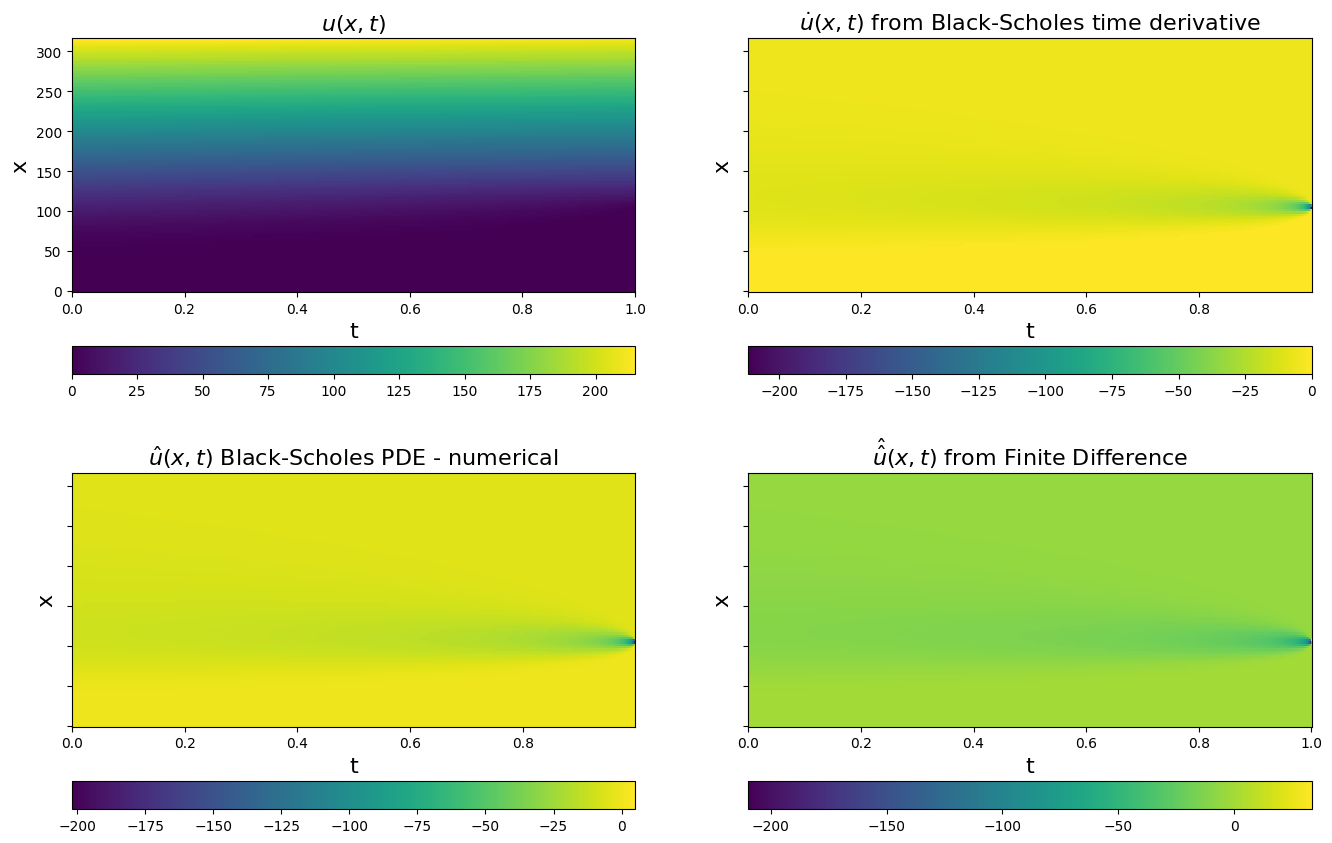

In [4]:
# n_arr = np.asarray([np.arange(0,spacesteps,1)]*timesteps).T
u_x = ps.FiniteDifference(axis=0,order = 6)._differentiate(u,t = dx)
u_xx = ps.FiniteDifference(axis=0,d=2,order = 8)._differentiate(u,t = dx)
u_t_ = ps.FiniteDifference(axis=1,order = 25)._differentiate(u,t = dt)
# v_dot = numerical_partial_black_scholes(u.T,r,sigma).T


# Plot u and u_dot
plt.figure(figsize=(16, 16))
plt.subplot(3, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)
plt.colorbar(orientation="horizontal")

# plt.subplot(3, 2, 5)
# plt.pcolormesh(t, x, v_dot)
# plt.xlabel("t", fontsize=16)
# plt.ylabel("x", fontsize=16)
# ax = plt.gca()
# ax.set_yticklabels([])
# plt.title(r"$\hat{\hat{\hat{u}}}(x, t)$ from DURA-MOS¸NEAGU", fontsize=16)
# plt.colorbar(orientation="horizontal")

u_dot = -(1/2)*((sigma**2)*(X.T[:,:-1]**2)*u_xx[:,:-1]) - (r*(X.T[:,:-1])*u_x[:,:-1]) + r*u[:,:-1]
plt.subplot(3, 2, 3)
plt.pcolormesh(t[:-1], x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\hat{u}(x, t)$ Black-Scholes PDE - numerical", fontsize=16)
plt.colorbar(orientation="horizontal")


plt.subplot(3, 2, 4)
plt.pcolormesh(t, x, u_t_)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\hat{\hat{u}}(x, t)$ from Finite Difference", fontsize=16)
plt.colorbar(orientation="horizontal")

plt.subplot(3, 2, 2)
plt.pcolormesh(t[:-1], x, u_t)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from Black-Scholes time derivative", fontsize=16)
plt.colorbar(orientation="horizontal")


# print('Error for DURA-MOS¸NEAGU Computation')
# print('RSE',np.sum((u_t - v_dot)**2)/np.sum((u_t - u_t.mean())**2))
# print('RMSE',(np.sqrt(np.sum((u_t - v_dot)**2).mean())))
print('Error for Finite Difference ')
print('RSE',np.sum((u_t_[:,:-1] - u_t)**2)/np.sum((u_t - u_t.mean())**2))
print('RMSE',(np.sqrt(np.sum((u_t - u_t_[:,:-1])**2).mean())))
print('Error for Numerical Black-Scholes')
print('RSE',np.sum((u_dot - u_t)**2)/np.sum((u_t - u_t.mean())**2))
print('RMSE',(np.sqrt(np.sum((u_dot - u_t)**2).mean())))

plt.show()

##### PySINDy

In [23]:
u = np.reshape(u, (len(x), len(t), 1))
u_dot  = np.reshape(u_dot, (*u_dot.shape, 1))
u_t  = np.reshape(u_t, (*u_t.shape, 1))
u_t_  = np.reshape(u_t_, (*u_t_.shape, 1))

# v_dot  = np.reshape(v_dot, (len(x), len(t), 1))
spatial_grid = np.reshape(X.T, (*X.T.shape, 1))

library_functions = [lambda x: x]
library_function_names = [lambda x: x]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_interaction = False,
    derivative_order=2,
    spatial_grid=x,
    include_bias=False,
    is_uniform=True,
    periodic=True # uniformly sampled in time
)

#Create Library with partial derivatives and spatial variable plus cross-terms
u_final = pde_lib.fit_transform(u)
u_final = np.concatenate((u_final,spatial_grid,spatial_grid**2),axis=2)
dic_var = {'x0':'u','x1':'u_x', 'x2':'u_xx','x3':'x','x4':'x^2'}
library_functions = [lambda x: x,lambda x,y: x*y]
library_function_names = [lambda x: dic_var[x],lambda x,y: dic_var[x] + '*' + dic_var[y]]
lib = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=False
)
lib_tr = lib.fit_transform(u_final)

In [75]:
# Add boundary conditional on T time of the derivative
# Create a new shape by adding 1 to the second dimension
original_shape = u_t.shape
new_shape = list(original_shape)
new_shape[1] += 1

_u_t = np.zeros(new_shape)
# Copy the original data into the new array up to the last layer

_u_t[:, :original_shape[1], :] = u_t



print('--------------------------PDE Black-scholes numerical-----------------------------')
#Fit the data using the numerical approximation
print('STLSQ Regression')
optimizer = ps.STLSQ()
model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u_final[:,:-1,:],x_dot = u_dot)
# print(model.score(u_test))
model.print()
print('Error Model prediction against analytical solution:')
pred = model.predict(u_final)
print('R2',model.score(x = u_final,x_dot = _u_t))
print('RSE',np.sum((pred.flatten() - _u_t.flatten())**2)/np.sum((_u_t.flatten() - _u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - _u_t.flatten())**2).mean())))


print('----------------------------Finite Difference--------------------------------')
#Fit the data using the finite difference approximation

print('STLSQ Regression')
optimizer = ps.STLSQ(threshold=0.004286285714285715, alpha=10000.0)
model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u_final,x_dot = u_t_)
# print(model.score(u_test))
model.print()
print('Error Model prediction against analytical solution:')
pred = model.predict(u_final)
print('R2',model.score(x = u_final,x_dot = _u_t))
print('RSE',np.sum((pred.flatten() - _u_t.flatten())**2)/np.sum((_u_t.flatten() - _u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - _u_t.flatten())**2).mean())))

print('\nMean threshold remove \n')
#Remove less participative terms
new_coef = threshold_remove(lib_tr,model.coefficients()[0],threshold = 0.05,axis=2,target = _u_t)
pred = lib_tr @ new_coef
print_model(new_coef,lib.get_feature_names())
print('Error Model prediction against analytical solution:')
print('RSE',np.sum((pred.flatten() - _u_t.flatten())**2)/np.sum((_u_t.flatten() - _u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - _u_t.flatten())**2).mean())))

print('*'*50)

print('----------------------------Weak Formulation--------------------------------')

library_functions = [lambda x: x, lambda x: x * x,lambda x: X.T,lambda x: X.T**2]
library_function_names = [lambda x: x,lambda x: x + '*' + x,lambda x: 'x',lambda x: 'x**2']

pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=500,
)

optimizer = ps.STLSQ(threshold=0.004286285714285715, alpha=10000.0)

model = ps.SINDy(feature_names = ['u'],feature_library=pde_lib, optimizer=optimizer)
model.fit(u)
model.print()
lib_weak = np.concatenate((lib_tr[:,:,:7],lib_tr[:,:,8:]),axis=2)
pred = lib_weak @ model.coefficients()[0]
print('Error Model prediction against analytical solution:')
print('RSE',np.sum((pred.flatten() - _u_t.flatten())**2)/np.sum((_u_t.flatten() - _u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - _u_t.flatten())**2).mean())))

print('\nMean threshold remove \n')
#Remove less participative terms
# Without u*x term
lib_weak = np.concatenate((lib_tr[:,:,:7],lib_tr[:,:,8:]),axis=2)
new_coef = threshold_remove(lib_weak,model.coefficients()[0],threshold = 4e-11,axis=2,target = _u_t)
pred = lib_weak @ new_coef
print_model(new_coef,model.get_feature_names())
print('Error Model prediction against analytical solution:')
print('RSE',np.sum((pred.flatten() - _u_t.flatten())**2)/np.sum((_u_t.flatten() - _u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - _u_t.flatten())**2).mean())))

print('*'*50)
# print('*'*50)

# print('----------------------------Ensemble method----------------------------')
# optimizer = ps.STLSQ(threshold=4e-2, alpha=5e2)
# # optimizer = ps.SR3(threshold=0.01,nu = .1 , max_iter=1000, tol=1e-10,thresholder='l0')
# # optimizer = ps.SSR(alpha=.1,kappa = .001,)

# model = ps.SINDy(feature_library=lib, optimizer=optimizer)
# model.fit(u_final, x_dot = u_t_,
#         library_ensemble =True, 
#         n_candidates_to_drop=5,
#         n_models = 300,
#         n_subset = len(t) // 2,
#         quiet=True)
# library_ensemble_coefs = model.coef_list

# mean_ensemble = np.mean(library_ensemble_coefs,axis=0)[0]
# median_ensemble = np.median(library_ensemble_coefs,axis=0)[0]

# print_model(mean_ensemble,lib.get_feature_names())
# print_model(median_ensemble,lib.get_feature_names())
# #Fit the data using ensemble methos on the finite difference values

# print('Error Model prediction against analytical solution:')
# optimizer.coef_ = median_ensemble
# pred = model.predict(u_final[:,:-1,:])
# print('R2',model.score(x = u_final[:,:-1,:],x_dot = u_t))
# print('RSE',np.sum((pred.flatten() - u_t.flatten())**2)/np.sum((u_t.flatten() - u_t.flatten().mean())**2))
# print('RMSE',(np.sqrt(np.sum((pred.flatten() - u_t.flatten())**2).mean())))

# print('\nMean threshold remove \n')
# #Remove less participative terms
# new_coef = threshold_remove(lib_tr[:,:-1,:],mean_ensemble,target = u_t,threshold = 0.1,axis=2)
# pred = lib_tr[:,:-1,:] @ new_coef
# print_model(new_coef,lib.get_feature_names())
# print('Error Model prediction against analytical solution:')
# print('RSE',np.sum((pred.flatten() - u_t.flatten())**2)/np.sum((u_t.flatten() - u_t.flatten().mean())**2))
# print('RMSE',(np.sqrt(np.sum((pred.flatten() - u_t.flatten())**2).mean())))


--------------------------PDE Black-scholes numerical-----------------------------
STLSQ Regression
(x0)' = 0.280 u + -5.348 u_x + 672.618 u_xx + -0.279 u*u_x + -9.180 u*u_xx + 105.495 u_x*u_xx + -15.036 u_xx*x
Error Model prediction against analytical solution:
R2 0.9822479325872054
RSE 0.017752067412794545
RMSE 247.48058923521052
----------------------------Finite Difference--------------------------------
STLSQ Regression
(x0)' = 0.051 u + -0.002 u*u_x + -1.209 u*u_xx + -0.050 u_x*x + -0.078 u_xx*x^2
Error Model prediction against analytical solution:
R2 0.9829985339256113
RSE 0.01700146607438872
RMSE 242.19203633722327

Mean threshold remove 

u_t = + 0.05 u + -0.05 u_x*x + -0.08 u_xx*x^2
Error Model prediction against analytical solution:
RSE 0.017109711090715924
RMSE 242.96180774860466
**************************************************
----------------------------Weak Formulation--------------------------------
(u)' = 0.050 u + -0.001 uu_1 + -0.050 xu_1 + -0.080 x**2u_11
Error Mo

(110, 1200, 1)

In [53]:

def threshold_remove(data,coef,target,threshold = 0.1,axis=1):
    #Iterate through all terms and force to 0 the ones which does not change the norm of the matrix more than the threshold
    for i in range(len(coef)):
        coef_ = np.delete(coef,i,axis=0)
        data_ = np.delete(data,i,axis=axis)

        matrix_org = data @ coef
        matrix_tg = data_ @ coef_
        if np.abs(np.linalg.norm(matrix_tg) - np.linalg.norm(matrix_org))/np.linalg.norm(matrix_org) < threshold:
            coef[i] = 0. 
    # Optimize the coefficients of the remaining terms
    idx_not_null = np.where(coef)
    data_ = data[:,:,idx_not_null[0]]
    x = np.reshape(data_,(data_.shape[0]*data_.shape[1],data_.shape[2]))
    y = np.ravel(target)
    c, r, rank, s = np.linalg.lstsq(x, y, rcond=None)
    coef[idx_not_null] = c
    return coef


#### Finding Hyperparams

In [17]:
# Define the parameter grid for hyperparameters
param_grid = {
    'threshold': np.linspace(1e-6,1e-2,15),  # Adjust these values as needed
    'alpha': np.linspace(1e-3,1e4,15),  # Adjust these values as needed
}

grind_hyper_search(u=u,u_dot=None,lib=pde_lib,opt=ps.STLSQ,param_grid=param_grid)

(73, 1200, 1)
[ 37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]


IndexError: index 94 is out of bounds for axis 0 with size 73